# Initial conditions
![](initial_conditions.png){#fig-initial_conditions}

## Introduction
A circuit with initial conditions consisting of a capacitor with an inital voltage and an inductor with initial current is analysed. 

## Circuit description
The circuit in @fig-initial_conditions has seven branches and four nodes. Capacitor, C1, has an initial voltage at t(0) and the inductor, L1, has an initial current at t(0). The voltage source V2 represents the initial voltage on the capacitor and current source, I1, represents the initial current flowing in the inductor. The circuit has a DC voltage source, V1. There a current controlled current source, F1, that is controlled by the current in V1.  

## Circuit analysis
The circuit was drawn using LTSpice and the netlist was pasted into the code. The [Heaviside](https://docs.sympy.org/latest/modules/functions/special.html) function is used to define the initial current and voltage on the inductor and capacitor. The Heaviside function is named after [Oliver Heaviside](https://en.wikipedia.org/wiki/Oliver_Heaviside), who made significant contributions to electrical engineering.  

The following Python modules are used.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

In [2]:
t = symbols('t',positive=True)  # t > 0

### Load the netlist
The netlist generated by LTSpice is pasted into the cell below and some edits were made to remove the inductor series resistance and the independent sources are set to their DC values.

In [3]:
net_list = '''
V1 1 0 1
R2 3 2 5
C1 3 4 1
V2 4 0 1
L1 1 2 3 
I1 1 2 1
F1 2 0 V1 2
'''

Generate the network equations.

In [4]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [5]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$I_{L1} + I_{V1} = - I_{1}$<br>$I_{F1} - I_{L1} + \frac{v_{2}}{R_{2}} - \frac{v_{3}}{R_{2}} = I_{1}$<br>$- C_{1} s v_{4} + v_{3} \left(C_{1} s + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{2}} = 0$<br>$- C_{1} s v_{3} + C_{1} s v_{4} + I_{V2} = 0$<br>$v_{1} = V_{1}$<br>$v_{4} = V_{2}$<br>$- I_{L1} L_{1} s + v_{1} - v_{2} = 0$<br>$I_{F1} - I_{V1} f_{1} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand and a symbolic soultion would take a lot of computing time. The equations are displace in matrix notation.

In [6]:
NE_sym

⎡         I_L1 + I_V1          ⎤        
⎢                              ⎥        
⎢                  v₂   v₃     ⎥   ⎡-I₁⎤
⎢    I_F1 - I_L1 + ── - ──     ⎥   ⎢   ⎥
⎢                  R₂   R₂     ⎥   ⎢I₁ ⎥
⎢                              ⎥   ⎢   ⎥
⎢              ⎛       1 ⎞   v₂⎥   ⎢ 0 ⎥
⎢-C₁⋅s⋅v₄ + v₃⋅⎜C₁⋅s + ──⎟ - ──⎥   ⎢   ⎥
⎢              ⎝       R₂⎠   R₂⎥   ⎢ 0 ⎥
⎢                              ⎥ = ⎢   ⎥
⎢  -C₁⋅s⋅v₃ + C₁⋅s⋅v₄ + I_V2   ⎥   ⎢V₁ ⎥
⎢                              ⎥   ⎢   ⎥
⎢              v₁              ⎥   ⎢V₂ ⎥
⎢                              ⎥   ⎢   ⎥
⎢              v₄              ⎥   ⎢ 0 ⎥
⎢                              ⎥   ⎢   ⎥
⎢     -I_L1⋅L₁⋅s + v₁ - v₂     ⎥   ⎣ 0 ⎦
⎢                              ⎥        
⎣        I_F1 - I_V1⋅f₁        ⎦        

The symbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [7]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Built a dictionary of element values.

In [8]:
element_values = SymMNA.get_part_values(network_df)
element_values

## Initial conditions
The SymPy Heaviside function is used to define the initial current and voltage on the inductor and capacitor.  

In [9]:
element_values[V1] = laplace_transform(Heaviside(t), t, s)[0]
element_values[V2] = laplace_transform(-0.2*Heaviside(t), t, s)[0]
element_values[I1] = laplace_transform(0.1*Heaviside(t), t, s)[0]
NE_ic = NE_sym.subs(element_values)
NE_ic

                                      ⎡-0.1 ⎤
                                      ⎢─────⎥
                                      ⎢  s  ⎥
                                      ⎢     ⎥
⎡           I_L1 + I_V1           ⎤   ⎢ 0.1 ⎥
⎢                                 ⎥   ⎢ ─── ⎥
⎢  I_F1 - I_L1 + 0.2⋅v₂ - 0.2⋅v₃  ⎥   ⎢  s  ⎥
⎢                                 ⎥   ⎢     ⎥
⎢-s⋅v₄ - 0.2⋅v₂ + v₃⋅(1.0⋅s + 0.2)⎥   ⎢  0  ⎥
⎢                                 ⎥   ⎢     ⎥
⎢     I_V2 - s⋅v₃ + 1.0⋅s⋅v₄      ⎥   ⎢  0  ⎥
⎢                                 ⎥ = ⎢     ⎥
⎢               v₁                ⎥   ⎢  1  ⎥
⎢                                 ⎥   ⎢  ─  ⎥
⎢               v₄                ⎥   ⎢  s  ⎥
⎢                                 ⎥   ⎢     ⎥
⎢      -3.0⋅I_L1⋅s + v₁ - v₂      ⎥   ⎢-0.2 ⎥
⎢                                 ⎥   ⎢─────⎥
⎣         I_F1 - 2.0⋅I_V1         ⎦   ⎢  s  ⎥
                                      ⎢     ⎥
                                      ⎢  0  ⎥
                                  

Solve the network equations and display the results.

In [10]:
U_ic = solve(NE_ic,X)

temp = ''
for i in U_ic.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_ic[i]))

Markdown(temp)

$v_{1} = \frac{1}{s}$<br>$v_{2} = \frac{13.0 s^{2} + 53.0 s + 10.0}{10.0 s^{3} + 50.0 s^{2} + 10.0 s}$<br>$v_{3} = \frac{- 2.0 s^{2} - 7.0 s + 10.0}{10.0 s^{3} + 50.0 s^{2} + 10.0 s}$<br>$v_{4} = - \frac{0.2}{s}$<br>$I_{V1} = \frac{- s - 4.0}{10.0 s^{2} + 50.0 s + 10.0}$<br>$I_{V2} = \frac{3.0 s + 12.0}{10.0 s^{2} + 50.0 s + 10.0}$<br>$I_{L1} = \frac{- s - 1.0}{10.0 s^{3} + 50.0 s^{2} + 10.0 s}$<br>$I_{F1} = \frac{- s - 4.0}{5.0 s^{2} + 25.0 s + 5.0}$<br>

The voltage on node 2 is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together). This helps SymPy solve the inverse Laplace transform.

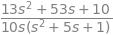

In [11]:
temp = U_ic[v2].nsimplify().simplify().expand().together()
temp

In [12]:
node_2_voltage = inverse_laplace_transform(temp, s, t)
node_2_voltage

In [13]:
func_node_2_voltage = lambdify(t, node_2_voltage) 

The voltage on node 3 is obtained in a sumular way.

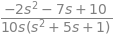

In [14]:
temp = U_ic[v3].nsimplify().simplify().expand().together()
temp

In [15]:
node_3_voltage = inverse_laplace_transform(temp, s, t)
node_3_voltage

In [16]:
func_node_3_voltage = lambdify(t, node_3_voltage) 

The plot below shows the node voltages versus time.

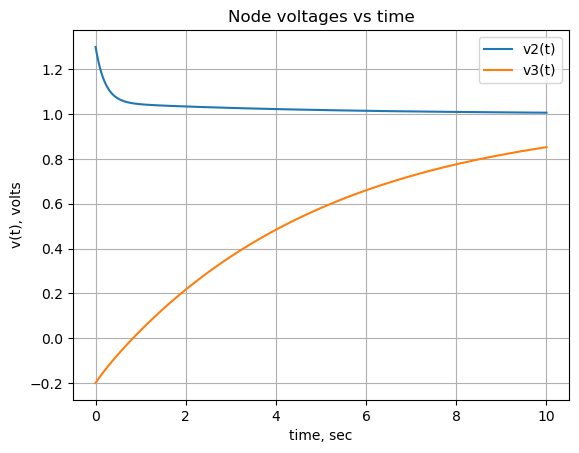

In [17]:
x = np.linspace(0, 10, 2000, endpoint=True)

plt.title('Node voltages vs time')

plt.plot(x, func_node_2_voltage(x),label='v2(t)')
plt.plot(x, func_node_3_voltage(x),label='v3(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## Summary
In this notebook, newtork equations were solved which had initial conditions, which were included in the network equations with their Laplace equilivents.   